In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from positions import *

In [44]:
with open('data.json', 'r') as j:
    game_data = json.loads(j.read())

In [41]:
for game in game_data:
    for player in game.keys():
        for turn in game[player].keys():
            for status in game[player][turn].keys():
                #print(status)
                #print(game[player][turn][status])
                break

We want to create a heatmap, the map will be the billiards table. The dimensions of the heat map will be related to the coordinates of the heatmap, meaning that a "square" of the heatmap will be related to its position in the table.

In [45]:
# We need to have all the positions the spheres have been, in order to do this we will create a df with the positions
positions = []
for game in game_data:
    for player in game.keys():
        for turn in game[player].keys():
            for status in game[player][turn].keys():
                if status == 'played':
                    for frame in game[player][turn][status].keys():
                        for position in game[player][turn][status][frame]['sphere_position']:
                            positions.append([int(position[0]), int(position[2])])
                else:
                    for position in game[player][turn][status]['sphere_position']:
                        positions.append([int(position[0]), int(position[2])])

positions_array = np.array(positions)

In [38]:
print(len(positions_array))


1680


(41, 83)


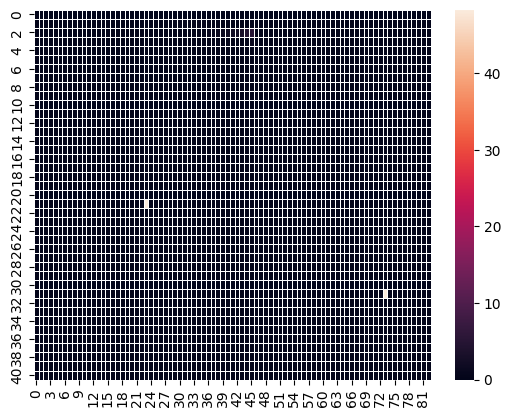

In [59]:
grid = [int(TABLE_WIDTH), int(TABLE_LENGTH)]
grid = np.full(grid, 0.0)

for pos in positions_array:
    pos_final_x = int(TABLE_WIDTH) - pos[0]
    pos_final_y = int(TABLE_LENGTH) - pos[1]
    #if grid[pos_final_x, pos_final_y] > 0:
    grid[pos_final_x, pos_final_y] += 0.1
print(grid.shape)
ax = sns.heatmap(grid, linewidth=0.4)
plt.show()

In [9]:
def total_shots(game_data, shots_correct = False):
    sum_shots = 0
    scored = 0
    for game in game_data:
        for player in game.keys():
            for turn in game[player].keys():
                for status in game[player][turn].keys():
                    if status == 'ended':
                        sum_shots += 1
                        if game[player][turn][status]['scored'] == True:
                            scored += 1
    if shots_correct:
        return sum_shots, scored
    return sum_shots


In [10]:
total_shots(game_data, shots_correct = True)

(2, 0)

In [233]:
def get_intermediate_positions(a, b, distance):
    # Return list with intermediate positions when ball goes too fast

    artificial_positions = []

    intermediate_positions = int(10 * distance)

    distance_to_add_x = (b[0] - a[0]) / intermediate_positions
    distance_to_add_y = (b[1] - a[1]) / intermediate_positions
    new_x, new_y = a[0], a[1]

    for i in range(intermediate_positions):
        new_x += distance_to_add_x
        new_y += distance_to_add_y

        artificial_positions.append((new_x, new_y))

    return artificial_positions



In [207]:
def get_position_list(df, cols = None):
    # Returns a list that contains all positions from the spheres
    # If cols == None, df only contains one column (one sphere only tracking)
    # Else, track all spheres
    # Only add the position if it is different from last (rounded to the first decimal)

    positions_list = []


    for column in cols:
        # For every sphere

        positions = list(df[column])
        last_x, last_y = round(positions[0][0]), round(positions[0][2])
        positions_list.append((last_x, last_y))

        for position in positions[1:]:
            # For every position of the sphere

            x, y = round(position[0], 2), round(position[2], 2)

            distance = get_distance((last_x, last_y), (x, y))
            if distance > 0.1:
                # If the sphere moves too fast, add intermediate positions

                artificial_pos = get_intermediate_positions((last_x, last_y), (x, y), distance)

                for pos in artificial_pos:
                    x, y = round(pos[0], 2), round(pos[1], 2)

                    if x != last_x or y != last_y:
                        positions_list.append((int(x*10), int(y*10)))
                        last_x, last_y = x, y

            elif x != last_x or y != last_y:
                # Only add if the sphere has moved significately
                positions_list.append((int(x*10), int(y*10)))
                last_x, last_y = x, y

        
    return positions_list


def get_distance(a, b):
    # Distance between two points

    return round(((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2) ** (1/2), 1)


In [429]:
def plot_heatmap(positions, title = None):

    # Grid size (heatmap correlation with table)
    grid = [int(TABLE_WIDTH)*10, int(TABLE_LENGTH)*10]
    grid = np.full(grid, 0.0)

    for item in positions:
        grid[item[0], item[1]] += 1

    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    ax.imshow(grid, interpolation="quadric", cmap='crest')

    ax.set(xticklabels=[], yticklabels=[])
    ax.set(xlabel="Table Width", ylabel="Table Height")
    ax.invert_xaxis()
    
    if title != None:
        ax.set(title=title)

    plt.savefig("C:/Users/Admin/Desktop/4t/EGRA/Billar/Billar-Carmboles/GameData/Metrics/" + "Heatmap " + title + ".png",
                    transparent = False, bbox_inches='tight')

    plt.close()


In [522]:
import pandas as pd
import plotly.express as px
import imageio
import os

def create_heamaps(data):

    plt.ioff()

    # Create turn heatmaps individually for every turn
    turns = list(data["TurnCount"].unique())
    for turn in turns:
        positions_list = get_position_list(data[data["TurnCount"] == turn], cols=["Pos1", "Pos2", "Pos3"])
        plot_heatmap(positions=positions_list, title="Turn " + str(turn))

    # Create gif from heatmaps
    path_temp = "C:/Users/Admin/Desktop/4t/EGRA/Billar/Billar-Carmboles/GameData/Metrics/"
    turn_heatmaps = []
    for file in os.listdir(path_temp):
        turn_heatmaps.append(imageio.v2.imread(path_temp + file))
    imageio.mimsave(path_temp + "Evolution.gif", turn_heatmaps, duration = 0.5)

    # Create heatmap from entire match
    positions_list = get_position_list(data, cols=["Pos1", "Pos2", "Pos3"])
    plot_heatmap(positions=positions_list, title="Entire Match")

In [525]:
def create_total_movement_graph(data):
    # Creates a graph with total movement of spheres by player

    sphere_cols = ["Pos1", "Pos2", "Pos3"]
    sphere_names = ["Yellow Ball", "White Ball", "Red Ball"]

    players = list(data["PlayerName"].unique())

    # Save total movement of sphere by player
    spheres_movement = []

    # Save total movement in turn by player
    spheres_movement_by_turn = dict.fromkeys(players)
    for player in players:
        spheres_movement_by_turn[player] = {}
        for sphere in sphere_cols:
            spheres_movement_by_turn[player][sphere] = []

    
    for player in players:

        player_data = data[data["PlayerName"] == player]
        
        for sphere in sphere_cols:
            sphere_data = player_data[sphere]
            spheres_movement.append(get_sphere_total_movement(sphere_data))

        turns = list(data["TurnCount"].unique())
        for turn in turns:

            turn_data = player_data[player_data["TurnCount"] == turn]

            for sphere in sphere_cols:
                sphere_data = turn_data[sphere]
                spheres_movement_by_turn[player][sphere].append(get_sphere_total_movement(sphere_data))

    # Create graph grid
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Sphere Data', size=25)
    fig.subplots_adjust(top=0.94)
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    movement_graph(spheres_movement, players, ax3)
    boxplot_graph(spheres_movement_by_turn, players[0], ax1)
    boxplot_graph(spheres_movement_by_turn, players[1], ax2)

    plt.savefig("C:/Users/Admin/Desktop/4t/EGRA/Billar/Billar-Carmboles/GameData/Metrics/" + "sphere_data.png")


def boxplot_graph(data, player, ax):
    # Create boxplot graph

    # Boxplot explication https://stackoverflow.com/questions/38794406/why-is-matplotlibs-notched-boxplot-folding-back-on-itself

    sphere_cols = ["Pos1", "Pos2", "Pos3"]
    sphere_names = ["Yellow Ball", "White Ball", "Red Ball"]
    x_axis = [1,2,3]

    # Data
    p_data = [data[player][sphere] for sphere in sphere_cols]

    bp = ax.boxplot(p_data, sphere_names, patch_artist=True,showfliers=False)
    ax.set(xticks=x_axis, xticklabels=sphere_names)
    ax.grid(linestyle = '--', linewidth = 0.5, axis = 'y')
    ax.set(title = "Distance Taveled By Turn of '" + player + "'")
    ax.set(ylabel="Distance traveled (cm)")

    colors = ['#ffff00', '#ffffff',
          '#ff0000']
 
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    return
    

def movement_graph(movement, players, ax):
    # Show graph
    
    labels = ["Yellow Ball", "White ball", "Red Ball"]
    x_axis = np.arange(len(labels))
    x_ticks = [i for i in range(0,int(max(movement)) + 200, 100)]

    #fig = plt.figure(figsize = (10, 5))
    bars = ax.barh(x_axis - 0.1, movement[:3], height=0.2, color ='green', label = players[0],)
    bars2 = ax.barh(x_axis + 0.1, movement[3:], height=0.2, color ='orange', label = players[1],)

    ax.set(title="Total distance traveled", xlabel="Distance (cm)", ylabel="Spheres", 
            yticks=x_axis, yticklabels=labels, xticks=x_ticks)
    ax.legend(players,loc="upper right")
    ax.grid(linestyle = '--', linewidth = 0.5, axis = 'x')
    ax.bar_label(bars, padding = 5, color='b', fontsize=14)
    ax.bar_label(bars2, padding = 5, color='b', fontsize=14)


def get_sphere_total_movement(data):
    # Return total movement of sphere

    positions = list(data)
    total_movement = 0

    for i in range(1, len(positions)):
        total_movement += get_distance((positions[i-1][0], positions[i-1][2]), (positions[i][0], positions[i][2]))

    return total_movement





In [526]:
data = pd.read_pickle("test.pkl")
create_heamaps(data)
create_total_movement_graph(data)